In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 391.9MB 42kB/s 
     |████████████████████████████████| 10.6MB 188kB/s 
     |████████████████████████████████| 471kB 53.5MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

### Data Preprocessing

In [ ]:
# Preproccesing

train_dir = os.path.join('/content/drive/My Drive/DataSet/input/Covid-Face-Mask-Detection/New Masks Dataset/Train')
validation_dir = os.path.join('/content/drive/My Drive/DataSet/input/Covid-Face-Mask-Detection/New Masks Dataset/Validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160) 
# upto 240 X 240 according to mobilenetv2
train_dataset = image_dataset_from_directory(train_dir,labels='inferred',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
print(os.getcwd())
type(train_dataset) 

Found 600 files belonging to 2 classes.
/content


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 306 files belonging to 2 classes.


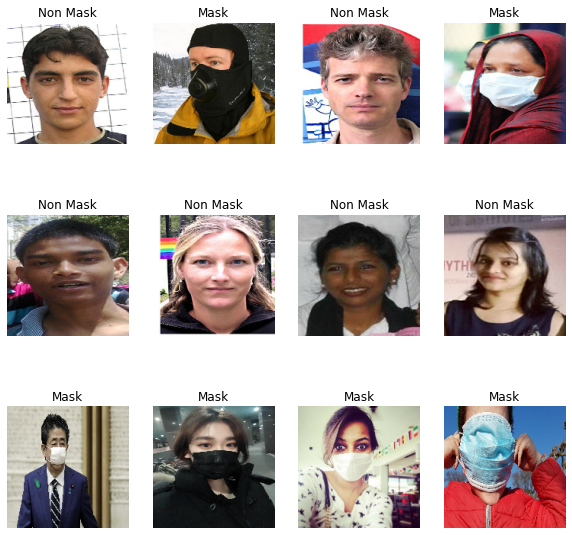

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
tot_valbatch = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(tot_valbatch // 5)
validation_dataset = validation_dataset.skip(tot_valbatch // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [ ]:
#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [ ]:
# data augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

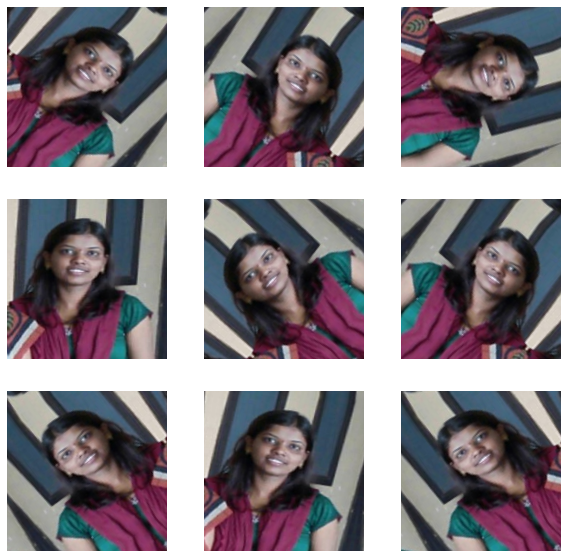

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Rescaling pixel value for mobilenetv2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### Creating the base model from MobileNet V2

In [ ]:
# Creating  the base model from  MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature Extraction

In [ ]:
# FReeze the base model
base_model.trainable = False

In [ ]:

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head as per requirement to build custom classifier




In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# len(model.trainable_variables)

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 133s 531ms/step - loss: 1.0149 - accuracy: 0.4643


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.98
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
19/19 [==============================] - 124s 7s/step - loss: 0.9579 - accuracy: 0.4917 - val_loss: 0.8385 - val_accuracy: 0.4752
Epoch 2/10
19/19 [==============================] - 22s 1s/step - loss: 0.8269 - accuracy: 0.5033 - val_loss: 0.7608 - val_accuracy: 0.4793
Epoch 3/10
19/19 [==============================] - 22s 1s/step - loss: 0.7752 - accuracy: 0.5133 - val_loss: 0.6892 - val_accuracy: 0.5702
Epoch 4/10
19/19 [==============================] - 23s 1s/step - loss: 0.7275 - accuracy: 0.5533 - val_loss: 0.6337 - val_accuracy: 0.6570
Epoch 5/10
19/19 [==============================] - 22s 1s/step - loss: 0.6638 - accuracy: 0.6233 - val_loss: 0.5923 - val_accuracy: 0.6860
Epoch 6/10
19/19 [==============================] - 21s 1s/step - loss: 0.5772 - accuracy: 0.6733 - val_loss: 0.5487 - val_accuracy: 0.7231
Epoch 7/10
19/19 [==============================] - 21s 1s/step - loss: 0.5675 - accuracy: 0.7100 - val_loss: 0.4837 - val_accuracy: 0.7851
Epoch 8/10
19/19 [=

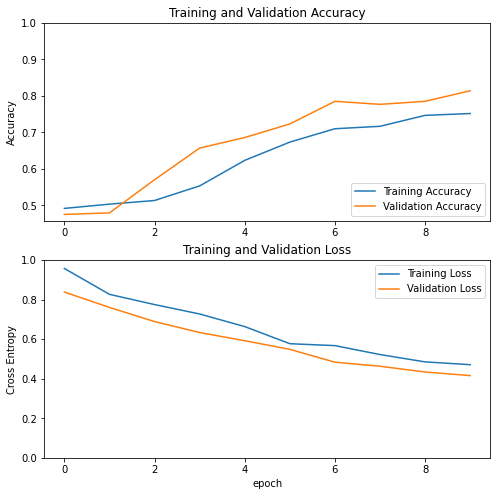

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [ ]:
base_model.trainable = True   # unfreeze

In [ ]:
# Total layers in base model
print("Number of layers in the base model: ", len(base_model.layers))

# from which layer we have to fine tune
fine_tune_at = 100

# Remaining layers should be freeze
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
19/19 [==============================] - 32s 1s/step - loss: 0.3445 - accuracy: 0.8608 - val_loss: 0.1224 - val_accuracy: 0.9835
Epoch 11/20
19/19 [==============================] - 27s 1s/step - loss: 0.1445 - accuracy: 0.9548 - val_loss: 0.0687 - val_accuracy: 0.9876
Epoch 12/20
19/19 [==============================] - 28s 1s/step - loss: 0.1139 - accuracy: 0.9684 - val_loss: 0.0542 - val_accuracy: 0.9917
Epoch 13/20
19/19 [==============================] - 27s 1s/step - loss: 0.0723 - accuracy: 0.9811 - val_loss: 0.0432 - val_accuracy: 0.9917
Epoch 14/20
19/19 [==============================] - 27s 1s/step - loss: 0.0580 - accuracy: 0.9846 - val_loss: 0.0393 - val_accuracy: 0.9917
Epoch 15/20
19/19 [==============================] - 27s 1s/step - loss: 0.0746 - accuracy: 0.9744 - val_loss: 0.0257 - val_accuracy: 0.9959
Epoch 16/20
19/19 [==============================] - 27s 1s/step - loss: 0.0439 - accuracy: 0.9798 - val_loss: 0.0364 - val_accuracy: 0.9959
Epoch 17/20
1

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

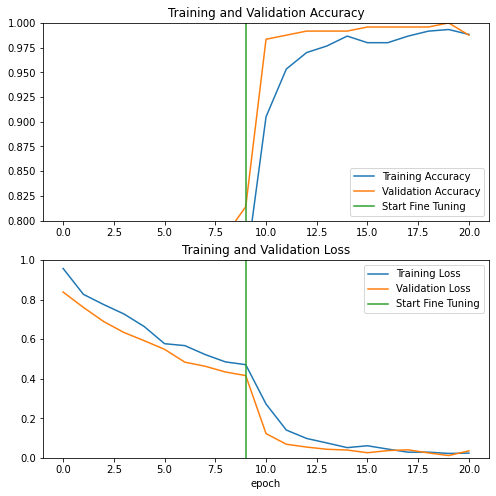

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 4s 543ms/step - loss: 0.0167 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1]
Labels:
 [1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1]


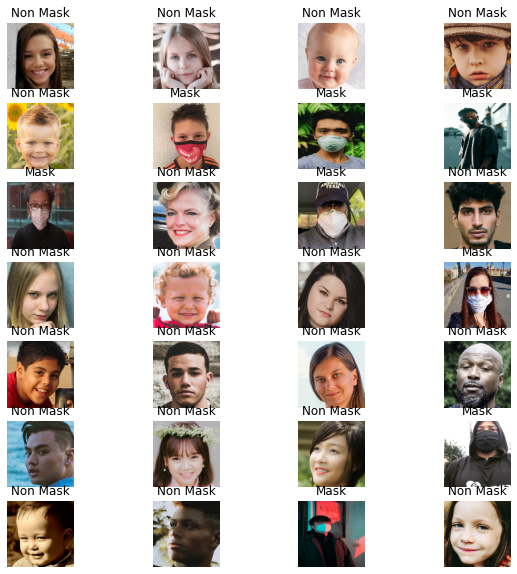

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(28):
  ax = plt.subplot(7, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")